In [3]:
import gc
import os
from pathlib import Path
import random
import sys

#from tqdm.notebook import tqdm
import numpy as np
import pandas as pd
import scipy as sp


import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
from IPython.core.display import display, HTML

# --- plotly ---
from plotly import tools, subplots
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.express as px
import plotly.figure_factory as ff
import plotly.io as pio
pio.templates.default = "plotly_dark"
pd.set_option('max_columns', 50)

In [8]:
data_train= pd.read_csv('train.csv')

In [9]:
data_test= pd.read_csv('test.csv')

In [10]:
data_train.head()

,Id,Province_State,Country_Region,Date,ConfirmedCases,Fatalities
0,1,NaN,Afghanistan,2020-01-22,0.0,0.0
1,2,NaN,Afghanistan,2020-01-23,0.0,0.0
2,3,NaN,Afghanistan,2020-01-24,0.0,0.0
3,4,NaN,Afghanistan,2020-01-25,0.0,0.0
4,5,NaN,Afghanistan,2020-01-26,0.0,0.0


In [11]:
data_test.head()

,ForecastId,Province_State,Country_Region,Date
0,1,NaN,Afghanistan,2020-03-26
1,2,NaN,Afghanistan,2020-03-27
2,3,NaN,Afghanistan,2020-03-28
3,4,NaN,Afghanistan,2020-03-29
4,5,NaN,Afghanistan,2020-03-30


In [12]:
data_train['Province_State'].unique().size, data_train['Country_Region'].unique().size


(131, 180)

In [13]:
data_test['Province_State'].unique().size, data_test['Country_Region'].unique().size

(131, 180)

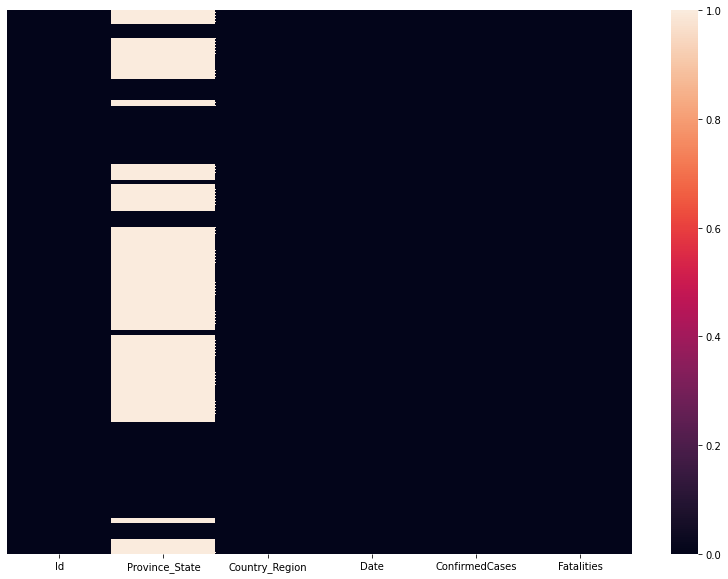

In [14]:
plt.figure(figsize=(14,10))
sns.heatmap(data_train.isnull(),yticklabels=False)

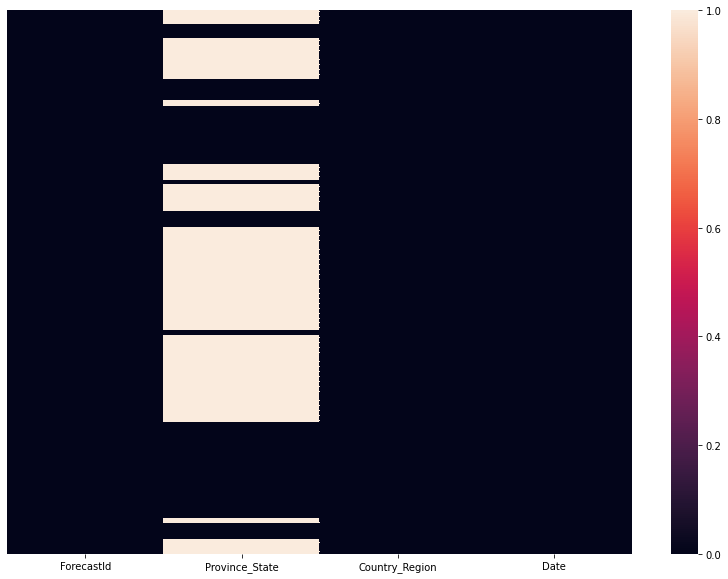

In [15]:
plt.figure(figsize=(14,10))
sns.heatmap(data_test.isnull(),yticklabels=False)

In [16]:
data_train.rename(columns={'Country_Region':'Country'}, inplace=True)
data_train.rename(columns={'Province_State':'State'}, inplace=True)


In [17]:
data_test.rename(columns={'Country_Region':'Country'}, inplace=True)
data_test.rename(columns={'Province_State':'State'}, inplace=True)


Text(0.5, 0, 'Date')

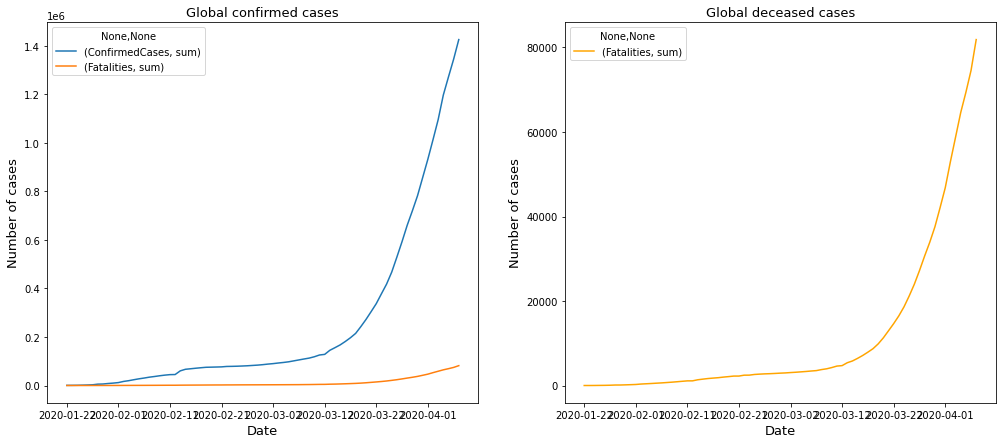

In [18]:
confirmed_total_date = data_train.groupby(['Date']).agg({'ConfirmedCases':['sum']})
fatalities_total_date = data_train.groupby(['Date']).agg({'Fatalities':['sum']})
total_date = confirmed_total_date.join(fatalities_total_date)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(17,7))
total_date.plot(ax=ax1)
ax1.set_title("Global confirmed cases", size=13)
ax1.set_ylabel("Number of cases", size=13)
ax1.set_xlabel("Date", size=13)
fatalities_total_date.plot(ax=ax2, color='orange')
ax2.set_title("Global deceased cases", size=13)
ax2.set_ylabel("Number of cases", size=13)
ax2.set_xlabel("Date", size=13)

In [19]:
data_train['State'].fillna("",inplace = True)

In [20]:
data_test['State'].fillna("",inplace = True)

In [21]:
data_train['Country'] = data_train['Country'] + ' ' + data_train['State']

del data_train['State']

In [22]:
data_test['Country'] = data_test['Country'] + ' ' + data_test['State']

del data_test['State']

In [25]:
train_dates=list(data_train.Date.unique())
print(f"Period : {len(data_train.Date.unique())} days")
print(f"From : {data_train.Date.min()} To : {data_train.Date.max()}")

Period : 77 days
From : 2020-01-22 To : 2020-04-07


In [26]:
train_dates=list(data_test.Date.unique())
print(f"Period : {len(data_test.Date.unique())} days")
print(f"From : {data_test.Date.min()} To : {data_test.Date.max()}")

Period : 43 days
From : 2020-03-26 To : 2020-05-07


In [27]:

data_train['Date'] = pd.to_datetime(data_train['Date'], infer_datetime_format=True)
data_train.loc[:, 'Date'] = data_train.Date.dt.strftime("%m%d")
data_train["Date"]  = data_train["Date"].astype(str)


In [28]:

data_test['Date'] = pd.to_datetime(data_test['Date'], infer_datetime_format=True)
data_test.loc[:, 'Date'] = data_test.Date.dt.strftime("%m%d")
data_test["Date"]  = data_test["Date"].astype(str)


In [29]:
month=[]
day=[]
for _ in data_train.Date:
    month.append(int(_[1]))
    day.append(int(_[2:]))

In [30]:
month1=[]
day1=[]
for _ in data_test.Date:
    month1.append(int(_[1]))
    day1.append(int(_[2:]))

In [31]:
data_train['month']=month
data_train['day']=day
del data_train['Date']

In [32]:
data_test['month']=month1
data_test['day']=day1
del data_test['Date']

In [36]:
from sklearn.preprocessing import LabelEncoder
lb = LabelEncoder()
data_train['Country'] = lb.fit_transform(data_train['Country'])

In [37]:
from sklearn.preprocessing import LabelEncoder
lb1 = LabelEncoder()
data_test['Country'] = lb1.fit_transform(data_test['Country'])

13.316373142178222

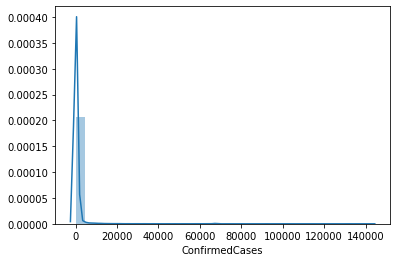

In [38]:
sns.distplot(data_train['ConfirmedCases'],bins=30)
data_train['ConfirmedCases'].skew()

22.122821713510877

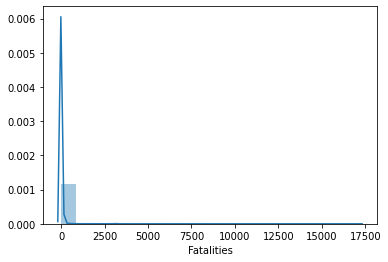

In [39]:
sns.distplot(data_train['Fatalities'],bins=20)
data_train['Fatalities'].skew()

In [40]:
target= ['ConfirmedCases', 'Fatalities']
for col in target:
    data_train[col]=np.log1p(data_train[col])
data_train.head()

,Id,Country,ConfirmedCases,Fatalities,month,day
0,1,0,0.0,0.0,1,22
1,2,0,0.0,0.0,1,23
2,3,0,0.0,0.0,1,24
3,4,0,0.0,0.0,1,25
4,5,0,0.0,0.0,1,26


In [41]:
del data_train['Id']
data_train.head()

,Country,ConfirmedCases,Fatalities,month,day
0,0,0.0,0.0,1,22
1,0,0.0,0.0,1,23
2,0,0.0,0.0,1,24
3,0,0.0,0.0,1,25
4,0,0.0,0.0,1,26


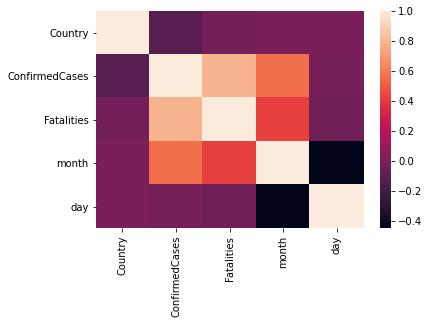

In [42]:
sns.heatmap(data_train.corr())

In [43]:
data_train['ConfirmedCases'] = data_train['ConfirmedCases'].apply(int)
data_train['Fatalities'] = data_train['Fatalities'].apply(int)
cases = data_train.ConfirmedCases
fatalities = data_train.Fatalities
del data_train['ConfirmedCases']
del data_train['Fatalities']

In [44]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
x_train = scaler.fit_transform(data_train)

In [45]:
from sklearn.preprocessing import MinMaxScaler
scaler1 = MinMaxScaler()
x_train1 = scaler.fit_transform(data_test)

In [46]:
df_train= pd.DataFrame(x_train,columns=data_train.columns)
df_train.head()

,Country,month,day
0,0.0,0.0,0.700000
1,0.0,0.0,0.733333
2,0.0,0.0,0.766667
3,0.0,0.0,0.800000
4,0.0,0.0,0.833333


In [47]:
df_test= pd.DataFrame(x_train1,columns=data_test.columns)
df_test.head()

,ForecastId,Country,month,day
0,0.000000,0.0,0.0,0.833333
1,0.000076,0.0,0.0,0.866667
2,0.000152,0.0,0.0,0.900000
3,0.000228,0.0,0.0,0.933333
4,0.000304,0.0,0.0,0.966667


In [48]:
del df_test['ForecastId']

In [49]:
from sklearn.model_selection import train_test_split, cross_val_score
X= df_train
y= cases
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101)

In [50]:
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics 


In [51]:
models=[]
models.append(('DTC',DecisionTreeRegressor()))
models.append(('KNC',KNeighborsRegressor()))
models.append(('LR',LinearRegression()))
models.append(('RFC',RandomForestRegressor()))
models.append(("MLP",MLPRegressor()))
models.append(("GBC",GradientBoostingRegressor()))

In [52]:
names=[]
for name,algo in models:
    algo.fit(X_train,y_train)
    prediction= algo.predict(X_test)
    a= metrics.mean_squared_error(y_test,prediction) 
    print("%s: %f "%(name, a))

DTC: 0.179928 
KNC: 2.887503 
LR: 4.177031 
RFC: 0.168708 


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:568: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.



MLP: 3.098125 
GBC: 1.996777 


In [53]:
rm= DecisionTreeRegressor()

In [54]:
rm.fit(X_train,y_train)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=None,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

In [55]:
prediction_cases= rm.predict(X_test)

In [56]:
compare = pd.DataFrame({'Prediction': prediction_cases, 'Test Data' : y_test})
compare.head(10)

,Prediction,Test Data
19406,0.0,0
5691,4.0,4
15854,0.0,0
11690,9.0,9
13712,0.0,0
18471,5.0,5
1119,2.0,2
4602,7.0,7
7691,6.0,6
8431,0.0,0


In [57]:
X_cases=df_test

In [58]:
pr_cases=rm.predict(X_cases)

In [59]:
X= df_train
y1= fatalities
X_train1, X_test1, y_train1, y_test1 = train_test_split(X, y1, test_size=0.2, random_state=101)

In [60]:
models=[]
models.append(('DTC',DecisionTreeRegressor()))
models.append(('KNC',KNeighborsRegressor()))
models.append(('LR',LinearRegression()))
models.append(('RFC',RandomForestRegressor()))
models.append(("MLP",MLPRegressor()))
models.append(("GBC",GradientBoostingRegressor()))

In [61]:
names=[]
for name,algo in models:
    algo.fit(X_train1,y_train1)
    prediction= algo.predict(X_test1)
    a= metrics.mean_squared_error(y_test1,prediction) 
    print("%s: %f "%(name, a))

DTC: 0.046467 
KNC: 1.047842 
LR: 1.106503 
RFC: 0.054962 
MLP: 0.989228 
GBC: 0.599561 


In [62]:
rm1=DecisionTreeRegressor()

In [63]:
rm1.fit(X_train1,y_train1)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=None,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

In [64]:
pred_fatalities=rm1.predict(X_test1)

In [65]:
compare1 = pd.DataFrame({'Prediction': pred_fatalities, 'Test Data' : y_test1})
compare1.head(10)

,Prediction,Test Data
19406,0.0,0
5691,1.0,1
15854,0.0,0
11690,4.0,4
13712,0.0,0
18471,2.0,1
1119,0.0,0
4602,2.0,2
7691,2.0,2
8431,0.0,0


In [66]:
X_fatalities= df_test

In [67]:
pr_fatalities=rm1.predict(X_fatalities)

In [68]:
test= pd.read_csv("test.csv")

In [69]:
sub = pd.DataFrame()
sub['ForecastId'] = test['ForecastId']
sub['ConfirmedCases'] = pr_cases
sub['Fatalities']= pr_fatalities
sub['ConfirmedCases'] = np.exp(sub['ConfirmedCases']) 
sub['Fatalities'] = np.exp(sub['Fatalities']) 

sub.to_csv('submission.csv',index=False)

In [70]:
subm= pd.read_csv('submission.csv')
subm.head()

,ForecastId,ConfirmedCases,Fatalities
0,1,1.0,1.0
1,2,1.0,1.0
2,3,1.0,1.0
3,4,1.0,1.0
4,5,1.0,1.0
